### Understanding euclidean distance between observed points and reference dataframe 

In [97]:
import pandas as pd
import numpy as np 
from scipy.spatial import distance
import tensorflow as tf 
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
df = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))
df.head(2)

,A,B,C,D
0,95,65,28,87
1,75,12,75,8


In [4]:
df_example = pd.DataFrame(np.random.randint(0,100,size=(1,4)), columns=list('ABCD')).iloc[0]
display(df_example)

A     1
B    94
C    44
D    77
Name: 0, dtype: int32

In [5]:
df_array = df_example.to_numpy()
df_array.shape 

(4,)


<!-- 
Distance = \sum_{col=0}^{Total\ Columns} Euclidean\ Distance(df[col], df_{Ref}[col])   -->
$$
d(p, q) = \sqrt({(p_1 - q_1)^2 + (p_2 - q_2)^2 + ... + (p_n - q_n)^2}) \newline 
d(p, q) = \sqrt(sum((p_i - q_i)^2 for\ i\ in\ range(n)))
$$

In [6]:
distances = df.agg(distance.euclidean, 1, v=df_example.to_numpy())
print(f'Distances:\n{distances}')
nearest_index = distances.idxmin()
nearest_index, min(distances)

Distances:
0     100.164864
1     133.873074
2      83.964278
3      94.773414
4      71.260087
         ...    
95     94.228446
96     59.211485
97     83.276647
98    105.470375
99    107.079410
Length: 100, dtype: float64


(32, 26.457513110645905)

### Hence, the row with the lowest euclidean distance is chosen as reference for this particular test-data

In [7]:
# df.loc[[nearest_index]], df_example

In [8]:
reference_point = df.loc[[nearest_index]]
print(reference_point.agg(distance.euclidean, 1, df_example.to_numpy()))
print(reference_point)
print()
df_example

32    26.457513
dtype: float64
    A   B   C   D
32  6  77  49  96



A     1
B    94
C    44
D    77
Name: 0, dtype: int32

In [9]:
# number of steps in integrated gradients
num_steps = 10

In [10]:
reference_point_arr = reference_point.iloc[0].to_numpy()
reference_point_arr.shape 

(4,)

In [11]:
reference_point_arr, df_array 

(array([ 6, 77, 49, 96]), array([ 1, 94, 44, 77]))

In [12]:
np.linspace(reference_point_arr, df_array, 5)

array([[ 6.  , 77.  , 49.  , 96.  ],
       [ 4.75, 81.25, 47.75, 91.25],
       [ 3.5 , 85.5 , 46.5 , 86.5 ],
       [ 2.25, 89.75, 45.25, 81.75],
       [ 1.  , 94.  , 44.  , 77.  ]])

In [13]:
# Returns 2000 evenly spaced samples, calculated over the interval [reference_point_arr, df_array]
interp_output = tf.convert_to_tensor(np.linspace(reference_point_arr, df_array, num_steps))

In [14]:
interp_output.shape 

TensorShape([10, 4])

In [15]:

model = models.Sequential([
    layers.Dense(128, input_shape=(4,), activation='relu', name='dense'),
    layers.Dropout(0.5, name='dropout'),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(1, activation='sigmoid', name='dense_3')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

D:\After\Fuse AI Trainee\proj\madi_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)            │ (None, 128)        │        640 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout (Dropout)        │ (None, 128)        │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_1 (Dense)          │ (None, 128)        │     16,512 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_1 (Dropout)      │ (None, 128)        │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_2 (Dense)          │ (None, 128)        │     16,512 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_2 (Dropout)      │ (None, 128)        │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_3 (Dense)          │ (None, 1)          │        129 │
└──────────────────────────┴────────────────────┴────────────┘

 Total params: 33,793 (132.00 KB)

 Trainable params: 33,793 (132.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
interp_output.shape 

TensorShape([10, 4])

In [17]:
with tf.GradientTape() as tape:
    tape.watch(interp_output)
    outs = model(interp_output)

In [18]:
outs.shape

TensorShape([10, 1])

In [19]:
outs , interp_output

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[1.2888042e-06],
        [1.6070846e-06],
        [1.9538404e-06],
        [2.3143193e-06],
        [2.6264904e-06],
        [2.9998455e-06],
        [3.4890888e-06],
        [4.0254195e-06],
        [4.4573767e-06],
        [5.0451472e-06]], dtype=float32)>,
 <tf.Tensor: shape=(10, 4), dtype=float64, numpy=
 array([[ 6.        , 77.        , 49.        , 96.        ],
        [ 5.44444444, 78.88888889, 48.44444444, 93.88888889],
        [ 4.88888889, 80.77777778, 47.88888889, 91.77777778],
        [ 4.33333333, 82.66666667, 47.33333333, 89.66666667],
        [ 3.77777778, 84.55555556, 46.77777778, 87.55555556],
        [ 3.22222222, 86.44444444, 46.22222222, 85.44444444],
        [ 2.66666667, 88.33333333, 45.66666667, 83.33333333],
        [ 2.11111111, 90.22222222, 45.11111111, 81.22222222],
        [ 1.55555556, 92.11111111, 44.55555556, 79.11111111],
        [ 1.        , 94.        , 44.        , 77.        ]])>)

In [20]:
gradients = tape.gradient(outs, interp_output)
gradients

<tf.Tensor: shape=(10, 4), dtype=float64, numpy=
array([[ 4.02633589e-08,  3.81116116e-09, -1.46516328e-07,
        -1.12856398e-07],
       [ 5.83518762e-08, -3.46154039e-09, -1.85339061e-07,
        -1.33202136e-07],
       [ 8.24097839e-08, -2.69497242e-08, -1.94900309e-07,
        -1.58828854e-07],
       [ 1.87055022e-07, -4.44061108e-08, -1.92857982e-07,
        -2.01217475e-07],
       [ 2.52547864e-07, -7.04147851e-08, -2.31302963e-07,
        -2.04786687e-07],
       [ 2.75134056e-07, -4.38490844e-08, -2.48920117e-07,
        -2.77831475e-07],
       [ 3.14332539e-07, -6.60230342e-08, -2.86600539e-07,
        -3.09136283e-07],
       [ 4.49587702e-07, -1.15903234e-07, -2.92640181e-07,
        -3.36088334e-07],
       [ 4.48435799e-07, -1.22887400e-07, -2.80918073e-07,
        -4.01722048e-07],
       [ 5.19263665e-07, -1.37477002e-07, -2.75344775e-07,
        -4.80740368e-07]])>

In [21]:
#gradients sum
# integral over alpha from 0 to 1 on dF/dx_i(alpha)
grad_sum = np.array(np.matrix(gradients).sum(axis=0).tolist()[0])
grad_sum 

array([ 2.62738167e-06, -6.27560754e-07, -2.33534033e-06, -2.61641006e-06])

In [22]:
sum(gradients[:,0]), sum(gradients[:,1]),sum(gradients[:,2]),sum(gradients[:,3]) 

(<tf.Tensor: shape=(), dtype=float64, numpy=2.62738166512122e-06>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-6.275607535854988e-07>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-2.335340326453661e-06>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-2.616410057498797e-06>)

## Sum of all gradients for every variable 

In [23]:
reference_point_arr, df_array

(array([ 6, 77, 49, 96]), array([ 1, 94, 44, 77]))

In [24]:
# for the attribution 
# IG = difference * grad_sum
# # ig_i = (x_i - x'_i) * integral over alpha from 0 to 1 on dF/dx_i(alpha)
difference_ = reference_point_arr-df_array
difference_


array([  5, -17,   5,  19])

In [25]:
grad_sum.shape, difference_.shape 

((4,), (4,))

In [26]:
attribution = np.multiply(grad_sum, difference_) / float(num_steps)
attribution 

array([ 1.31369083e-06,  1.06685328e-06, -1.16767016e-06, -4.97117911e-06])

In [27]:
sum(attribution)

-3.7583051588185866e-06

In [28]:
denom = sum([abs(val) for val in attribution])
denom 

8.519393386130502e-06

In [29]:
attribution/denom , np.matrix(gradients)

(array([ 0.15420004,  0.12522644, -0.13706025, -0.58351327]),
 matrix([[ 4.02633589e-08,  3.81116116e-09, -1.46516328e-07,
          -1.12856398e-07],
         [ 5.83518762e-08, -3.46154039e-09, -1.85339061e-07,
          -1.33202136e-07],
         [ 8.24097839e-08, -2.69497242e-08, -1.94900309e-07,
          -1.58828854e-07],
         [ 1.87055022e-07, -4.44061108e-08, -1.92857982e-07,
          -2.01217475e-07],
         [ 2.52547864e-07, -7.04147851e-08, -2.31302963e-07,
          -2.04786687e-07],
         [ 2.75134056e-07, -4.38490844e-08, -2.48920117e-07,
          -2.77831475e-07],
         [ 3.14332539e-07, -6.60230342e-08, -2.86600539e-07,
          -3.09136283e-07],
         [ 4.49587702e-07, -1.15903234e-07, -2.92640181e-07,
          -3.36088334e-07],
         [ 4.48435799e-07, -1.22887400e-07, -2.80918073e-07,
          -4.01722048e-07],
         [ 5.19263665e-07, -1.37477002e-07, -2.75344775e-07,
          -4.80740368e-07]]))

In [30]:
# getting absolute value for the attribution/explanation
attribution_ = [abs(v) for v in attribution]
attribution_ 

[1.31369083256061e-06,
 1.066853281095348e-06,
 1.1676701632268305e-06,
 4.971179109247714e-06]

In [31]:
reference_point

,A,B,C,D
32,6,77,49,96


In [32]:
attribution 

array([ 1.31369083e-06,  1.06685328e-06, -1.16767016e-06, -4.97117911e-06])

In [33]:
df.index 

RangeIndex(start=0, stop=100, step=1)

In [34]:
attribution_dict = {}
reference_point_dict = {}
for i, col in enumerate(df_example.index):
    print(col)
    attribution_dict[col] = attribution[i]
    reference_point_dict[col] = reference_point.iloc[0][col]
attribution_dict, reference_point_dict

A
B
C
D


({'A': 1.31369083256061e-06,
  'B': 1.066853281095348e-06,
  'C': -1.1676701632268305e-06,
  'D': -4.971179109247714e-06},
 {'A': 6, 'B': 77, 'C': 49, 'D': 96})

In [35]:
df.iloc[10]['A']

97

### Plotting the Attribution Plot 

In [36]:
anomaly_score = model.predict(np.matrix(np.array(df_example)))
anomaly_score 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[5.045138e-06]], dtype=float32)

In [37]:
df_example_val = pd.Series(df_example).astype(float)
reference_point_val = reference_point.iloc[0].astype(float)
attribution_val = pd.Series(attribution_dict).astype(float)
df_example_val, reference_point, attribution_dict

(A     1.0
 B    94.0
 C    44.0
 D    77.0
 Name: 0, dtype: float64,
     A   B   C   D
 32  6  77  49  96,
 {'A': 1.31369083256061e-06,
  'B': 1.066853281095348e-06,
  'C': -1.1676701632268305e-06,
  'D': -4.971179109247714e-06})

In [38]:
df_attribution = pd.concat([df_example_val, reference_point_val, attribution_val], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

In [39]:
df_attribution

,observed_value,expected_value,attribution
A,1.0,6.0,0.000001
B,94.0,77.0,0.000001
C,44.0,49.0,-0.000001
D,77.0,96.0,-0.000005


In [40]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.07:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()


C:\Users\OMEN\AppData\Local\Temp\ipykernel_21092\36954115.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  center_color_index  = int(num_p_score_steps*anomaly_score)
C:\Users\OMEN\AppData\Local\Temp\ipykernel_21092\36954115.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  center_text = "%.2f" %(anomaly_score)


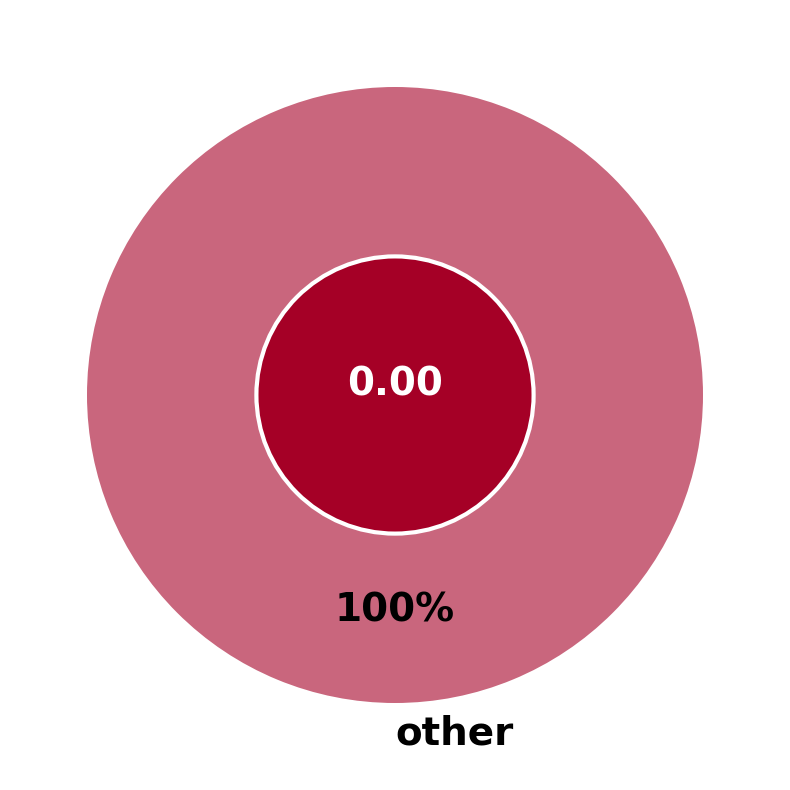

In [41]:
plot_attribution(df_attribution, anomaly_score) 

          observed_value  expected_value  attribution
Feature1        3.745401        1.559945     0.009284
Feature2        9.507143        0.580836     0.437468
Feature3        7.319939        8.661761     0.375464
Feature4        5.986585        6.011150     0.095773
Feature5        1.560186        7.080726     0.082010
Anomaly Score: 0.18340450985343382


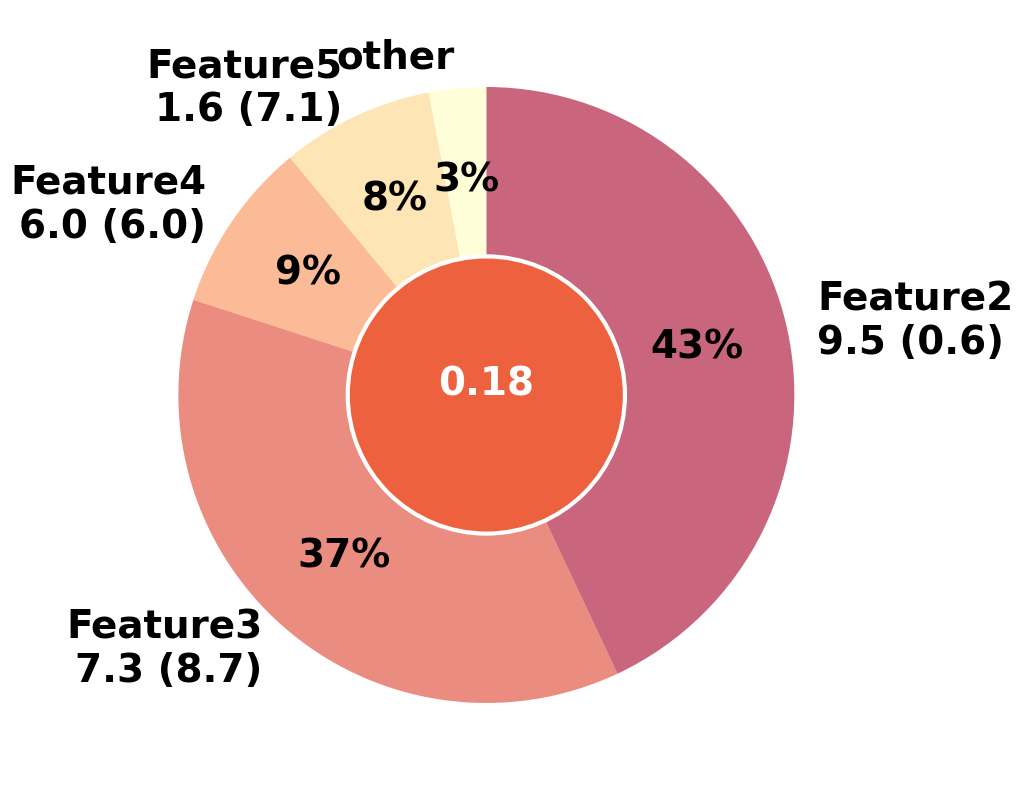

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate random data for a DataFrame
np.random.seed(42)  # For reproducibility

# Create a demo DataFrame with 5 columns: observed_value, expected_value, and attribution
df_attribution = pd.DataFrame({
    'observed_value': np.random.uniform(0, 10, 5),  # Random observed values between 0 and 10
    'expected_value': np.random.uniform(0, 10, 5),  # Random expected values between 0 and 10
    'attribution': np.random.uniform(0, 1, 5)       # Random attribution values between 0 and 1
}, index=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])

# Normalize the attribution column to sum up to 1
df_attribution['attribution'] /= df_attribution['attribution'].sum()

# Generate a random anomaly score between 0 and 1
anomaly_score = np.random.uniform(0, 1)

print(df_attribution)
print("Anomaly Score:", anomaly_score)


plot_attribution(df_attribution, anomaly_score)


In [43]:
def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
      series_color = colors[ix]
      ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
      ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(24)

    for sp in ax.spines:
       ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

    plt.grid(True)
    plt.show()

### Gradient Series

In [52]:
type(reference_point_dict )  

dict

In [53]:
nearest_reference_point = pd.Series(reference_point_dict)
nearest_reference_point

A     6
B    77
C    49
D    96
dtype: int32

In [55]:
nearest_reference_point.to_frame(), nearest_reference_point.to_frame().T

(    0
 A   6
 B  77
 C  49
 D  96,
    A   B   C   D
 0  6  77  49  96)

In [81]:
reference_ = nearest_reference_point.to_frame().T
custom_data = pd.DataFrame(df_array).T
print(type(reference_), type(custom_data))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [91]:
print(reference_.iloc[0].dtypes)
print(custom_data.iloc[0].dtypes)

print(reference_.columns)
print(custom_data.columns)

custom_data.columns = reference_.columns 

print(reference_.columns)
print(custom_data.columns)

reference_.iloc[0], custom_data.iloc[0]
# reference_.shape, custom_data.shape 

int32
int32
Index(['A', 'B', 'C', 'D'], dtype='object')
RangeIndex(start=0, stop=4, step=1)
Index(['A', 'B', 'C', 'D'], dtype='object')
Index(['A', 'B', 'C', 'D'], dtype='object')


(A     6
 B    77
 C    49
 D    96
 Name: 0, dtype: int32,
 A     1
 B    94
 C    44
 D    77
 Name: 0, dtype: int32)

In [92]:
delta_normalized = reference_.iloc[0] - custom_data.iloc[0]
delta_normalized 

A     5
B   -17
C     5
D    19
Name: 0, dtype: int32

In [109]:
df_grad = pd.DataFrame(np.matrix(gradients))
df_grad.head(20)

,0,1,2,3
0,4.026336e-08,3.811161e-09,-1.465163e-07,-1.128564e-07
1,5.835188e-08,-3.461540e-09,-1.853391e-07,-1.332021e-07
2,8.240978e-08,-2.694972e-08,-1.949003e-07,-1.588289e-07
3,1.870550e-07,-4.440611e-08,-1.928580e-07,-2.012175e-07
4,2.525479e-07,-7.041479e-08,-2.313030e-07,-2.047867e-07
5,2.751341e-07,-4.384908e-08,-2.489201e-07,-2.778315e-07
6,3.143325e-07,-6.602303e-08,-2.866005e-07,-3.091363e-07
7,4.495877e-07,-1.159032e-07,-2.926402e-07,-3.360883e-07
8,4.484358e-07,-1.228874e-07,-2.809181e-07,-4.017220e-07
9,5.192637e-07,-1.374770e-07,-2.753448e-07,-4.807404e-07


In [110]:
df_grad.columns 

RangeIndex(start=0, stop=4, step=1)

In [111]:
s = pd.Series([1, 2, 3, 4])
print(s.cumsum())

0     1
1     3
2     6
3    10
dtype: int64


In [112]:
df_grad.cumsum()

,0,1,2,3
0,4.026336e-08,3.811161e-09,-1.465163e-07,-1.128564e-07
1,9.861524e-08,3.496208e-10,-3.318554e-07,-2.460585e-07
2,1.810250e-07,-2.660010e-08,-5.267557e-07,-4.048874e-07
3,3.680800e-07,-7.100621e-08,-7.196137e-07,-6.061049e-07
4,6.206279e-07,-1.414210e-07,-9.509166e-07,-8.108915e-07
5,8.957620e-07,-1.852701e-07,-1.199837e-06,-1.088723e-06
6,1.210094e-06,-2.512931e-07,-1.486437e-06,-1.397859e-06
7,1.659682e-06,-3.671964e-07,-1.779077e-06,-1.733948e-06
8,2.108118e-06,-4.900838e-07,-2.059996e-06,-2.135670e-06
9,2.627382e-06,-6.275608e-07,-2.335340e-06,-2.616410e-06


In [115]:
df_grad.columns 

RangeIndex(start=0, stop=4, step=1)

In [117]:
df_grad[0].cumsum()/float(len(df_grad)) * delta_normalized[0]

C:\Users\OMEN\AppData\Local\Temp\ipykernel_21092\3270896656.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_grad[0].cumsum()/float(len(df_grad)) * delta_normalized[0]


0    2.013168e-08
1    4.930762e-08
2    9.051251e-08
3    1.840400e-07
4    3.103140e-07
5    4.478810e-07
6    6.050472e-07
7    8.298411e-07
8    1.054059e-06
9    1.313691e-06
Name: 0, dtype: float64

C:\Users\OMEN\AppData\Local\Temp\ipykernel_21092\1889041708.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]


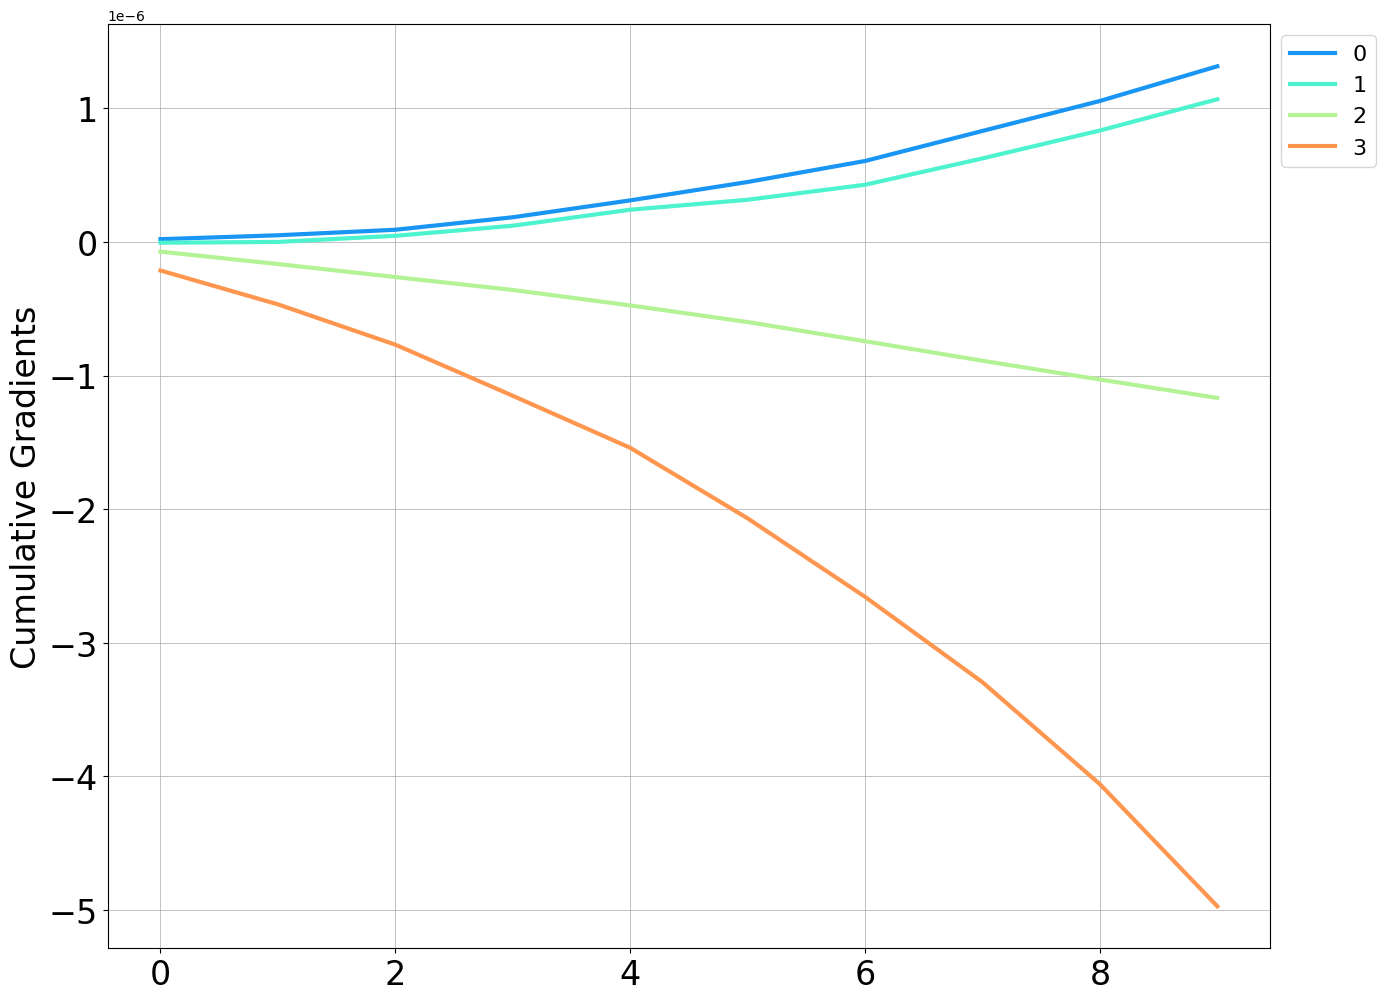

In [98]:
plot_gradient_series(df_grad, delta_normalized)